#### DL/DLOps (2023)

# Lab Assignment 8: Weights & Biases

Submitted By **Debonil Ghosh [ M21AIE225 ]**

**Question 1 [100 marks]**

Train a ResNet18 model for classification on even classes of CIFAR-10 (for  students with even roll no)/ odd classes of FashionMNIST (for students with odd roll no) for 30 epochs. Analyze the training of model using wandb library and “weights & biases” tool covered in the class.

In [1]:
!pip install wandb -qU


In [2]:
# Log in to your W&B account
import wandb
wandb.login()


wandb: Currently logged in as: ghosh-11. Use `wandb login --relogin` to force relogin


True

In [3]:
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Available device ==> {device}')


Available device ==> cuda:0


Filtering other than ODD classes 1,3,5,7,9 as roll number is odd (M21AIE225)

In [5]:
def filter_dataset(dataset_full):
    # Selecting ODD classes 1,3,5,7,9 as roll number is odd (M21AIE225)
    targets = np.array(dataset_full.targets)
    idx = (targets == 1) | (targets == 3) | (
        targets == 5) | (targets == 7) | (targets == 9)
    dataset_full.targets = np.floor(targets[idx]/2).astype(int)
    dataset_full.data = dataset_full.data[idx]
    dataset_full.classes = [dataset_full.classes[c] for c in [1, 3, 5, 7, 9]]
    return dataset_full


Dataset is **FashionMNIST** as roll number is odd

In [6]:
transform = T.Compose(
    [T.ToTensor(),
        T.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
train_set = filter_dataset(train_set)
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True)
test_set = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)
test_set = filter_dataset(test_set)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
print(train_set.data.shape)
print(train_set.classes)


torch.Size([30000, 28, 28])
['Trouser', 'Dress', 'Sandal', 'Sneaker', 'Ankle boot']


In [7]:
def get_model(act_fn=None, out_classes=len(test_set.classes)):
    model = torchvision.models.resnet18(
        weights=None)
    model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                                  stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
    model.fc = torch.nn.Linear(model.fc.in_features, out_classes)
    if act_fn != None:
        model.relu = getattr(torch.nn, act_fn)()
        for i in range(4):
            for j, module in enumerate(model.get_submodule(f'layer{i+1}')):
                module.relu = getattr(torch.nn, act_fn)()
    model = model.to(device)
    return model


print(get_model())


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [9]:
# Train the model
def model_training(model, criterion, optimizer, trainloader, testloader, num_epochs=10):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        epoch_start = time.time()
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(labels.cpu().detach(
            ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += metrics.accuracy_score(labels.cpu().detach(
                ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
        loss_list.append([train_loss, val_loss, train_acc, val_acc])
        wandb.log({"epoch": epoch+1, "train/train_loss": loss, "val/val_loss": val_loss,
                  "train/train_accuracy": train_acc, "val/val_accuracy": val_acc, "epoch_time": (time.time()-epoch_start)})
    print(
        f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list), time.time()-start, loss_list[-1][2], loss_list[-1][3]


In [10]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})
import pandas as pd


def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

    plt.figure(figsize=(10, 10))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    plt.show()
    plt.savefig(
        f'confusion_mat_{title}_{time.time()}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    print('\nConfusion Matrix:')
    print(cm.to_markdown())
    wandb.log({"accuracy_score": overallAccuracy, "f1_score": f1_score, })


In [11]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:, 2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:, 3], linestyle='-', label="Validation Accuracy")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()


In [12]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"] +
                        [test_set.classes[i] for i in range(len(test_set.classes))])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy(
        )*255), test_set.classes[pred], test_set.classes[targ], *prob.numpy())
    wandb.log({"predictions_table": table}, commit=False)


In [19]:
def run_trial(config):
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project=wandb_project,

        # track hyperparameters and run metadata
        config=config
    )
    # Copy your config
    config = wandb.config
    lr = config.learning_rate
    epoch = config.epochs
    act_fn = config.activation_fn
    optimizer_name = config.optimizer_name

    model = get_model(act_fn)
    wandb.watch(model)

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list, t, train_a, test_a = model_training(
        model, criterion, optimizer, trainloader, testloader, num_epochs=epoch)
    wandb.log({
        "Activation": act_fn,
        "Optimisers": optimizer_name,
        "learning_rate": lr,
        "Epoch": epoch,
        "Training Time": t,
        "Training Accuracy": train_a,
        "Test Accuracy": test_a,
    })
    plot_training_graphs(loss_list)
    model.eval()
    with torch.no_grad():
        test_labels = []
        test_output = []
        for batch_idx, batch in enumerate(testloader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            test_labels += y.cpu()
            test_output += torch.argmax(y_hat, dim=1).cpu()
            # Log one batch of images to the dashboard, always same batch_idx.
            if batch_idx % 100 == 0:
                log_image_table(x, y_hat.argmax(axis=1),
                                y, y_hat.softmax(dim=1))

        test_labels = np.array(test_labels)
        test_output = np.array(test_output)
        metric = confusionMatrixAndAccuracyReport(
            test_labels, test_output, test_set.classes, title=f'Resnet18_{act_fn}_{optimizer_name}')
    # 🐝 Close your wandb run
    wandb.finish()


In [14]:
wandb_project = "m21aie225-lab-assignment-8"



In [15]:
# 2: Define the search space
sweep_configuration = {
    'method': 'grid',
    'metric': {'goal': 'maximize', 'name': 'f1_score'},
    'parameters':
    {
        'learning_rate': {'values': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]},
        'activation_fn': {'values': ['ReLU', 'Tanh', 'GELU']},
        'optimizer_name': {'values': ['Adam', 'Adagrad', 'RMSprop', 'SGD']},
    }
}


Epoch: 1 (0m 22s) 	Training Loss: 0.174, 	Test Loss: 0.106,  	Training acc: 0.94, 	Test acc: 0.96, 
Epoch: 2 (0m 44s) 	Training Loss: 0.101, 	Test Loss: 0.088,  	Training acc: 0.97, 	Test acc: 0.97, 
Epoch: 3 (1m 6s) 	Training Loss: 0.076, 	Test Loss: 0.085,  	Training acc: 0.97, 	Test acc: 0.97, 
Epoch: 5 (1m 51s) 	Training Loss: 0.063, 	Test Loss: 0.111,  	Training acc: 0.98, 	Test acc: 0.96, 
Epoch: 6 (2m 13s) 	Training Loss: 0.058, 	Test Loss: 0.085,  	Training acc: 0.98, 	Test acc: 0.97, 
Epoch: 7 (2m 37s) 	Training Loss: 0.050, 	Test Loss: 0.086,  	Training acc: 0.98, 	Test acc: 0.98, 
Epoch: 8 (3m 0s) 	Training Loss: 0.045, 	Test Loss: 0.085,  	Training acc: 0.98, 	Test acc: 0.97, 
Epoch: 9 (3m 23s) 	Training Loss: 0.041, 	Test Loss: 0.080,  	Training acc: 0.99, 	Test acc: 0.98, 
Epoch: 10 (3m 46s) 	Training Loss: 0.031, 	Test Loss: 0.079,  	Training acc: 0.99, 	Test acc: 0.98, 
Epoch: 11 (4m 8s) 	Training Loss: 0.034, 	Test Loss: 0.078,  	Training acc: 0.99, 	Test acc: 0.98, 
E

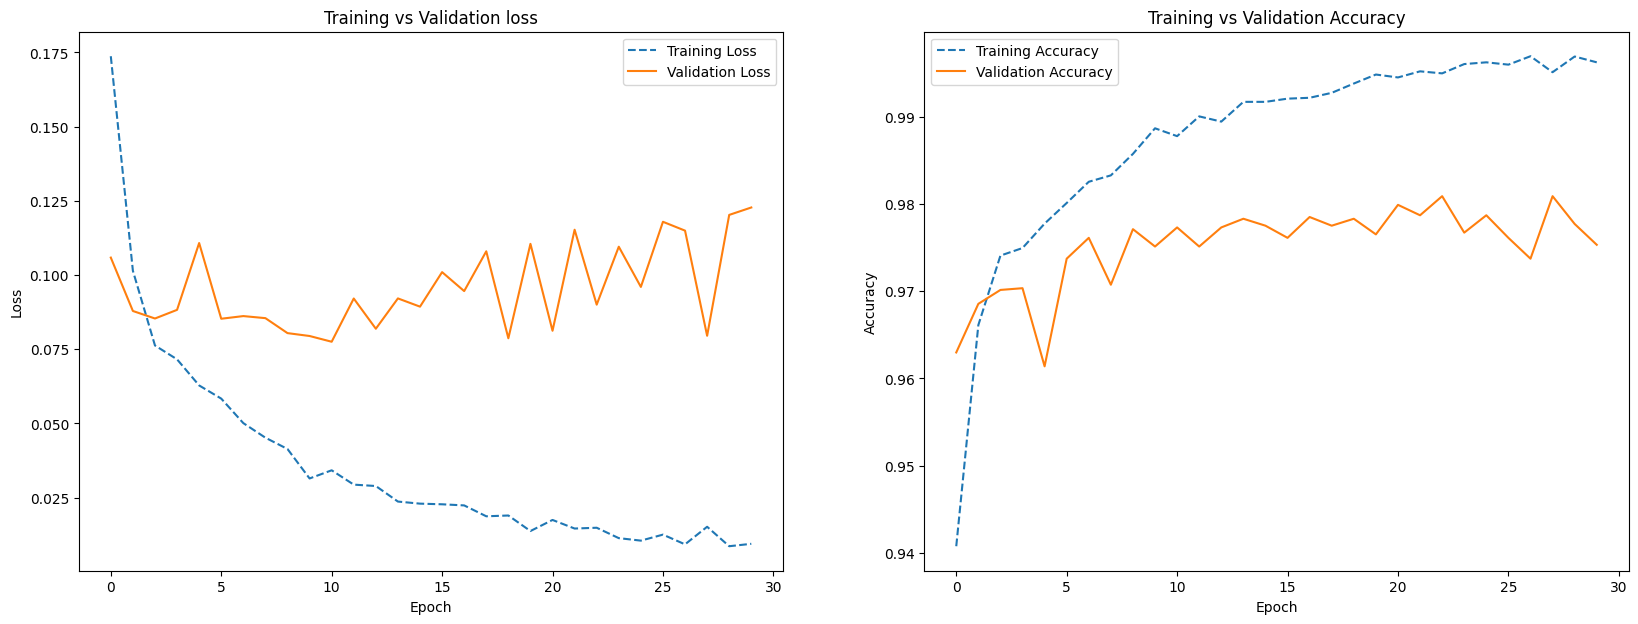

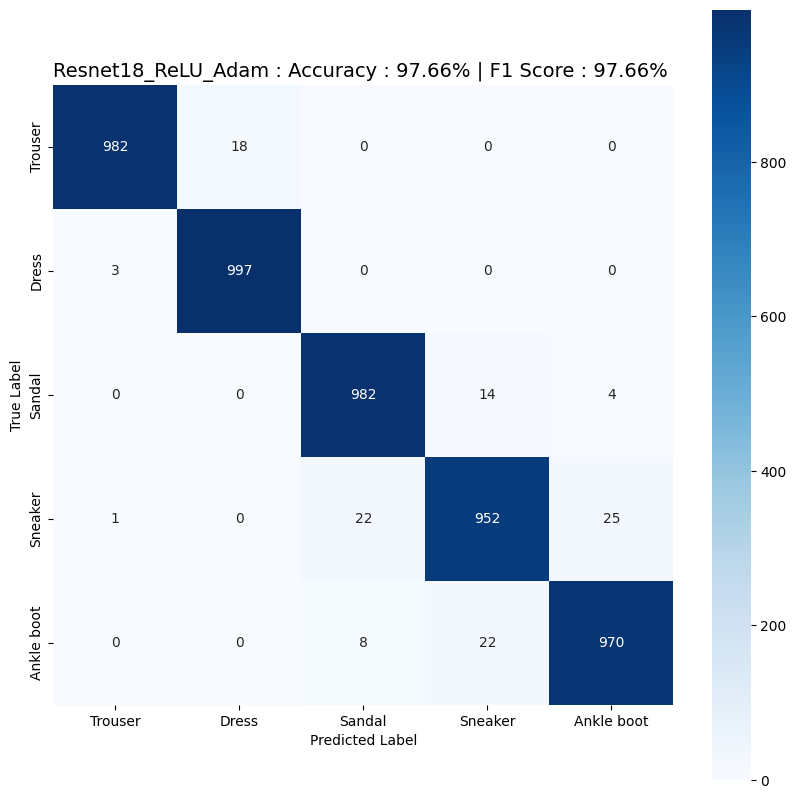

Accuracy: 97.660%
F1 Score: 97.658%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.982 |   0.997 |    0.982 |     0.952 |         0.97 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       982 |      18 |        0 |         0 |            0 |
| Dress        |         3 |     997 |        0 |         0 |            0 |
| Sandal       |         0 |       0 |      982 |        14 |            4 |
| Sneaker      |         1 |       0 |       22 |       952 |           25 |
| Ankle boot   |         0 |       0 |        8 |        22 |          970 |


Epoch,▁
Test Accuracy,▁
Training Accuracy,▁
Training Time,▁
accuracy_score,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_time,▃▁▂▃▃▅██▄▄▃▃▄▃▂▄▃▄▄▃▃▃▄▄▄▁█▅▃▅
f1_score,▁
learning_rate,▁
train/train_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train/train_loss,▃▁▁▂▅▁▁▁▁▂▁▆▁█▁▁▁▁▄▁▁▃▁▁▁▁▁▁█▁


Epoch: 1 (0m 22s) 	Training Loss: 0.178, 	Test Loss: 0.132,  	Training acc: 0.94, 	Test acc: 0.96, 
Epoch: 2 (0m 45s) 	Training Loss: 0.092, 	Test Loss: 0.109,  	Training acc: 0.97, 	Test acc: 0.96, 
Epoch: 3 (1m 7s) 	Training Loss: 0.065, 	Test Loss: 0.101,  	Training acc: 0.98, 	Test acc: 0.96, 
Epoch: 4 (1m 30s) 	Training Loss: 0.051, 	Test Loss: 0.102,  	Training acc: 0.98, 	Test acc: 0.97, 
Epoch: 5 (1m 52s) 	Training Loss: 0.044, 	Test Loss: 0.098,  	Training acc: 0.98, 	Test acc: 0.97, 
Epoch: 6 (2m 14s) 	Training Loss: 0.035, 	Test Loss: 0.087,  	Training acc: 0.99, 	Test acc: 0.97, 
Epoch: 7 (2m 37s) 	Training Loss: 0.029, 	Test Loss: 0.123,  	Training acc: 0.99, 	Test acc: 0.97, 
Epoch: 8 (2m 59s) 	Training Loss: 0.027, 	Test Loss: 0.097,  	Training acc: 0.99, 	Test acc: 0.97, 
Epoch: 9 (3m 22s) 	Training Loss: 0.022, 	Test Loss: 0.113,  	Training acc: 0.99, 	Test acc: 0.97, 
Epoch: 10 (3m 44s) 	Training Loss: 0.021, 	Test Loss: 0.094,  	Training acc: 0.99, 	Test acc: 0.97, 


In [ ]:
activation_fns = ['ReLU','Tanh','GELU']
optimisers = ['Adam','Adagrad','RMSprop','SGD']
learning_rates = [ 1e-3, 1e-4, 1e-5]
epoch = 30

for act_fn in activation_fns:
    for optimizer_name in optimisers:
      for lr in learning_rates:
        config={
              "learning_rate": lr,
              "architecture": "ResNet18",
              "dataset": "FashionMNIST",
              "epochs": epoch,
              'activation_fn': act_fn,
              'optimizer_name':optimizer_name,
          }
        run_trial(config)
# 3: Start the sweep
#sweep_id = wandb.sweep(sweep=sweep_configuration, project=wandb_project)
#wandb.agent(sweep_id, function=run_trial, count=2)